In [112]:
from psaw import PushshiftAPI
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.offsets import MonthEnd

import seaborn as sns

In [2]:
api = PushshiftAPI()      #api usada para puxar comentários do reddit

In [ ]:
start_epoch=int(datetime(2019, 1, 1).timestamp())

scraping = pd.DataFrame(api.search_comments(after=start_epoch,          #comentários a partir de 2019
                        subreddit='bitcoin',                            #do subreddit /r/bitcoin
                        filter=['body', 'date', 'score']                #com data, número de votos e corpo do texto
                        ))
scraping = scraping.drop(['created', 'd_'], axis = 1)

scraping['created_utc'] = pd.to_datetime(scraping['created_utc'],unit='s') 
scraping = scraping.sort_values(by='created_utc')                       #organizados em data

In [ ]:
scraping['TBPolarity'] = pd.Series(dtype='float')                       #criando colunas
scraping['TBSubjectivity'] = pd.Series(dtype='float')

def textblob_pol(body):
    
    return TextBlob(body).sentiment.polarity                            #definindo funções para trabalhar com apply

def textblob_sub(body):
    
    return TextBlob(body).sentiment.subjectivity

scraping['TBPolarity'] = scraping['body'].apply(textblob_pol)           #função de positividade do comentário

scraping['TBSubjectivity'] = scraping['body'].apply(textblob_sub)       #subjetividade

scraping.to_pickle('dados_bitcoin.pkl')                                 #gerando o arquivo utilizado no trabalho

In [3]:
base = pd.read_pickle('dadoscorretos.pkl')                              #abrindo ele

base['score']=base['score'].abs()                                       #tomando votos em módulo como indicação de importância (por hipótese)
base['dia'] = pd.to_datetime(base['created_utc'].dt.date)               #organizando

base['weight'] = base['score']/base.groupby('dia')['score'].transform('sum') #dando peso para comentários se baseando no total de votos do dia
base['value']=base['TBPolarity']*base['weight']                         #valor que cada comentário tem para o sentimento geral do dia
base['dt_month_year'] = base['created_utc'].dt.to_period('M')

In [73]:
preco_btc = pd.read_csv('btcusd.csv', skiprows=1).sort_values(by='Date')   #dados do bitcoin extraídos do cryptodatadownload.com

preco_btc['Date'] = pd.to_datetime(preco_btc['Date'], infer_datetime_format=True)

preco_btc['month_end'] = pd.to_datetime(preco_btc['Date'], format="%Y%m") + MonthEnd(0)

preco_btc['month_end_bool'] = (preco_btc['month_end'] == preco_btc['Date']).astype(int) #boolean para pegar o ultimo dia do mes

preco_btc['dt_month_year'] = preco_btc['Date'].dt.to_period('M')

preco2019 = preco_btc[preco_btc['Date'] >= '2019']
preco2019

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,month_end,month_end_bool,dt_month_year
582,1.546301e+09,2019-01-01,BTCUSD,3691.86,3841.17,3651.02,3826.09,10364.91,3.846253e+07,2019-01-31,0,2019-01
581,1.546387e+09,2019-01-02,BTCUSD,3826.09,3916.57,3770.07,3890.79,9536.46,3.659365e+07,2019-01-31,0,2019-01
580,1.546474e+09,2019-01-03,BTCUSD,3890.79,3893.80,3758.07,3787.57,8715.63,3.335490e+07,2019-01-31,0,2019-01
579,1.546560e+09,2019-01-04,BTCUSD,3787.57,3849.00,3730.00,3820.25,8951.89,3.388354e+07,2019-01-31,0,2019-01
578,1.546646e+09,2019-01-05,BTCUSD,3820.25,3874.12,3775.00,3798.62,6205.09,2.378895e+07,2019-01-31,0,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.597277e+09,2020-08-13,BTCUSD,11566.45,11802.09,11274.14,11795.95,15369.25,1.777590e+08,2020-08-31,0,2020-08
3,1.597363e+09,2020-08-14,BTCUSD,11795.95,11865.97,11651.24,11779.00,13797.44,1.622473e+08,2020-08-31,0,2020-08
2,1.597450e+09,2020-08-15,BTCUSD,11779.00,11989.98,11688.00,11859.24,12566.34,1.492883e+08,2020-08-31,0,2020-08
1,1.597536e+09,2020-08-16,BTCUSD,11859.24,11940.00,11686.53,11918.84,8911.33,1.055127e+08,2020-08-31,0,2020-08


In [115]:
agg = base.set_index('created_utc').groupby(pd.Grouper(freq='D')).sum()

In [116]:
base_monthly = base.groupby('dt_month_year', as_index=False).sum()[['dt_month_year', 'value']]

In [117]:
reddcorr = pd.merge(left=preco2019, left_on='Date',                     #pegando dias onde temos ambos os dados
         right=agg, right_on='created_utc')

reddcorr_m=pd.merge(left=preco2019[preco2019['month_end_bool']==1],     #pegando meses onde temos ambos os dados
         right=base_monthly, on='dt_month_year')

In [ ]:
# sns.pairplot(reddcorr, hue='dt_month_year', diag_kind='hist')

In [118]:
def commentcorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " lags atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com comentários do lag anterior:", np.corrcoef(dado1[k:h], dado2[:-8])[0][1])
        else:
            print("Correlação com comentários de ", 1+i, " lags atrás:", np.corrcoef(dado1[k:h], dado2[:-8])[0][1])
        if np.corrcoef(dado1[k:h], dado2[:-8])[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h], dado2[:-8])[0][1]
            max=i+1

In [119]:
commentcorr(reddcorr_m['Close'], reddcorr_m['value'])                                #aplicando a função à base de comentários do reddit

Correlação com comentários do lag anterior: -0.2857976308609017
Correlação com comentários de  2  lags atrás: -0.6591102229513092
Correlação com comentários de  3  lags atrás: -0.6426826982076997
Correlação com comentários de  4  lags atrás: -0.2115047888155508
Correlação com comentários de  5  lags atrás: 0.12080074950523827
Correlação com comentários de  6  lags atrás: 0.32517920583321025
Correlação com comentários de  7  lags atrás: -0.016498243254228526
Lag de maior correlação: 6  lags atrás


In [120]:
commentcorr(reddcorr['Close'], reddcorr['value'])                                #aplicando a função à base de comentários do reddit

Correlação com comentários do lag anterior: 0.0368245830225779
Correlação com comentários de  2  lags atrás: 0.03860449409260005
Correlação com comentários de  3  lags atrás: 0.04205005267600763
Correlação com comentários de  4  lags atrás: 0.03604325828316604
Correlação com comentários de  5  lags atrás: 0.028584474005855818
Correlação com comentários de  6  lags atrás: 0.030188268328582384
Correlação com comentários de  7  lags atrás: 0.028792405064350494
Lag de maior correlação: 3  lags atrás


In [1]:
#Para comentários, tomaremos comentários de 3 dias atrás para as previsões

In [103]:
dado = pd.read_excel('market_analysis_news.xlsx')                       #notícias extraídas por scraping do site cointelegraph.com

In [104]:
dado

,Link,Date,Title,Content,Views
0,https://cointelegraph.com/news/top-5-crypto-pe...,2018-11-03,"Top Crypto Performers Overview: Bitcoin Cash, ...",The views and opinions expressed here are sole...,18841
1,https://cointelegraph.com/news/top-5-crypto-pe...,2018-11-18,"Top 5 Crypto Performers Overview: XEM, Ripple,...",The views and opinions expressed here are sole...,19060
2,https://cointelegraph.com/news/top-5-crypto-pe...,2018-11-24,"Top 5 Crypto Performers Overview: XEM, Ripple,...",The views and opinions expressed here are sole...,36308
3,https://cointelegraph.com/news/top-5-crypto-pe...,2018-12-02,"Top 5 Crypto Performers Overview: TRON, Liteco...",Critics are pointing to large energy consumpti...,27758
4,https://cointelegraph.com/news/top-5-crypto-pe...,2018-12-09,"Top 5 Crypto Performers Overview: BSV, XEM, TR...","In a bear market, the sentiment is most bearis...",16545
...,...,...,...,...,...
421,https://cointelegraph.com/news/record-ethereum...,2020-08-15,Record Ethereum Network Use and Gas Fees Pose ...,The number of Ethereum network transactions mo...,16768
422,https://cointelegraph.com/news/eth-options-dat...,2020-08-16,ETH Options Data Suggest $500 Ethereum Price I...,Open interest on Ether (ETH) futures grew by 2...,21790
423,https://cointelegraph.com/news/bitcoin-investo...,2020-08-17,Bitcoin Investors Swap for Ethereum â€˜Wrapped...,Demand for Wrapped Bitcoin (WBTC) has been gro...,32815
424,https://cointelegraph.com/news/bitcoin-price-b...,2020-08-17,"Bitcoin Price Breaks $12K, but Is It the Final...","In the previous weeks, altcoins gained momentu...",24953


In [126]:
dado['TBPolarity'] = pd.Series(dtype='float')
dado['TBSubjectivity'] = pd.Series(dtype='float')

def textblob_pol(body):
    
    return TextBlob(body).sentiment.polarity                         #aplicando o processo feito com os comentários do reddit

def textblob_sub(body):
    
    return TextBlob(body).sentiment.subjectivity

dado['TBPolarity'] = dado['Content'].apply(textblob_pol)

dado['TBSubjectivity'] = dado['Content'].apply(textblob_sub)

dado.to_pickle('noticias.pkl')

In [127]:
news = pd.read_pickle('noticias.pkl')

news['Date'] = pd.to_datetime(news['Date'])
news=news.loc[(news['Date']> '2018-12-31') & (news['Date']< '2020-08-19')]     #mesma coisa     

news['weight'] = news['Views']/news.groupby('Date')['Views'].transform('sum')
news['value']=news['TBPolarity']*news['weight']

In [128]:
newsagg = news.set_index('Date').groupby(pd.Grouper(freq='D')).sum()

In [129]:
newsagg.reset_index(inplace=True)#tomando o índice original para uma operação a seguir, pode ser removido se trocarmos o for por outro método
newsagg['dummy'] = ''             #apenas utilizado no for

In [135]:
for i in range(len(newsagg)):                                                  #triste
    if newsagg['value'][i] != 0:                                      #esse for é utilizado pra fazer o decay de notícias, assim não temos
        newsagg.loc[i, 'dummy'] = 0                                   #dias com valor nulo de sentimento de notícias relacionadas a bitcoin.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 0):   #Basicamente, ele checa se o dia anterior teve notícias, e se não teve
        newsagg.loc[i, 'dummy'] = 1                                   #ele vê quantos dias atrás houveram notícias através do dummy.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 1):   #Note que o método depende do índice, logo devemos tirar o índice de
        newsagg.loc[i, 'dummy'] = 2                                   #data.
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 2):   #Para alterar, basta encontrar outra maneira de saber quantos dias 
        newsagg.loc[i, 'dummy'] = 3                                   #atrás houve a última notícia de modo preciso, para poder operar
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 3):   #o decaimento da importância do sentimento. 
        newsagg.loc[i, 'dummy'] = 4
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 4):   #A lógica para o decaimento é a seguinte: consideramos que em um dia
        newsagg.loc[i, 'dummy'] = 5                                   #sem notícias, a última notícia postada é a mais importante, descontada
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 5):   #pelo tempo. Ao surgir uma nova, a anterior se torna irrelevante.
        newsagg.loc[i, 'dummy'] = 6
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 6):
        newsagg.loc[i, 'dummy'] = 7
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 7):
        newsagg.loc[i, 'dummy'] = 8
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 8):
        newsagg.loc[i, 'dummy'] = 9
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 9):
        newsagg.loc[i, 'dummy'] = 10
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 10):
        newsagg.loc[i, 'dummy'] = 11
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 11):
        newsagg.loc[i, 'dummy'] = 12
    elif (newsagg['value'][i] == 0) & (newsagg['dummy'][i-1] == 12):
        newsagg.loc[i, 'dummy'] = 13
    else:
        newsagg.loc[i, 'dummy'] = 'idk'

In [136]:
newsagg['value'] = newsagg['value'].replace(to_replace=0, method='ffill')*1/(1+newsagg['dummy'])
#já sabendo o número de dias sem notícias, preenchemos os valores e descontamos com uma função inversa (arbitrária)

In [137]:
corrnoticias = pd.merge(left=preco2019, left_on='Date',
         right=newsagg, right_on='Date')

In [138]:
def newscorr(dado1, dado2):                                          #função que avalia o melhor número de dias de lag
    dummy=0                                                         #através da correlação entre os dados extraídos e os dados do btc
    max = 0                                                         #dado 1 começa a partir da i+1-ésima, logo é o dado que queremos prever
    for i in range(15):
        if i == 7:
            print("Lag de maior correlação:", max, " dias atrás")
            return 
        k=i+1
        h=i-7
        if i==0:
            print("Correlação com notícias do dia anterior:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        else:
            print("Correlação com notícias de ", 1+i, " dias atrás:", np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1])
        if np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]>dummy:
            dummy = np.corrcoef(dado1[k:h].astype('float64'), dado2[:-8].astype('float64'))[0][1]
            max=k

In [139]:
newscorr(corrnoticias['Close'], corrnoticias['value'])

Correlação com notícias do dia anterior: 0.30890369099116266
Correlação com notícias de  2  dias atrás: 0.30758127625508713
Correlação com notícias de  3  dias atrás: 0.30811443380130094
Correlação com notícias de  4  dias atrás: 0.3021061508292821
Correlação com notícias de  5  dias atrás: 0.2980700292835614
Correlação com notícias de  6  dias atrás: 0.2823065343560923
Correlação com notícias de  7  dias atrás: 0.27499871056835357
Lag de maior correlação: 1  dias atrás


In [28]:
#Para as notícias, tomaremos então lag do dia anterior

In [29]:
#introduzindo agora média móvel para tornar as previsões mais suaves.

In [140]:
def melhorMA(btc, dado):
    max=0
    value=0
    for i in range(200):
        lagged =  dado.rolling(window=i+1).mean().dropna()
        if np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]>value:
            value = np.corrcoef(btc[i:].astype('float64'), lagged.astype('float64'))[0][1]
            max=i+1
    print(max, value)
    return

In [145]:
melhorMA(corrnoticias['Close'], corrnoticias['value'])

8 0.47290374953695125


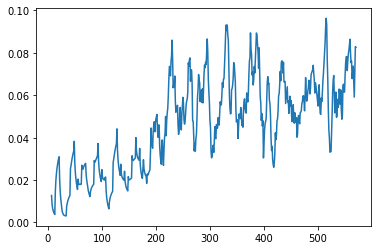

In [144]:
plt.plot(corrnoticias['value'].rolling(window=8).mean().dropna())